# RGI-07: Region 12 (Caucasus and Middle East)

F. Maussion & S. Galos, June 2021

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from utils import mkdir

## Files and storage paths

In [2]:
# Region of interest 
reg = 12

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '12_rgi60_CaucasusMiddleEast.zip')

In [3]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')
box_file = os.path.join(support_dir, 'RGI07_R12_UCA.tar.gz')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
toprint = []
for subid in shp.subm_id.unique():
    s_loc = shp.loc[shp.subm_id == subid]
    s = ''
    for c in ['subm_id', 'analysts', 'src_date']:
        toprint = s_loc[c].unique()
        if c != 'src_date':
            s += ' ' + (str(toprint[0]))
        else:
            for d in toprint:
                s += ' ' + d[:4]
    print(s)

 76.0 Nosenko, Gennadi (Gennady) 2004
 79.0 Nosenko, Gennadi (Gennady) 2004
 81.0 Nosenko, Gennadi (Gennady) 2004
 83.0 Nosenko, Gennadi (Gennady) 2004
 87.0 Nosenko, Gennadi (Gennady) 2004
 327.0 Khromova, Tatyana 2001
 341.0 Seliverstov, Yriy 2000
 423.0 Nosenko, Gennadi (Gennady) 2004
 424.0 Nosenko, Gennadi (Gennady) 1999
 425.0 Khromova, Tatyana 1999
 426.0 Nosenko, Gennadi (Gennady) 1999
 427.0 Nosenko, Gennadi (Gennady) 2001
 428.0 Nosenko, Gennadi (Gennady) 2004
 429.0 Nosenko, Gennadi (Gennady) 2004
 588.0 Ashkan, Farokhnia; Karimi, Neamat; Sara, Sheshangosht 2011
 642.0 Tielidze, Levan 2014 2013 2014 2014 2011 2016
 643.0 Tielidze, Levan 1987 1985 1986 1986 1986 1987
 644.0 Tielidze, Levan 1960
 662.0 Sarikaya, Mehmet Akif 2008 2006 2006 2004 2008 2009 2011
 724.0 Tielidze, Levan 1999 2000 2000 2000 1999 2002


### Apply selection criteria to create the RGI7 data subset

In [6]:
# try to get the data relevant for RGI07 and select by attributes - 
# for Caucasus we use 'subm_id' 642 by analyst 'Tielidze, Levan' which corresponds to the most recent (ca. 2013)
# of three available data sets for Caucasus by this anayst (others are from around 1960 and appr. 1985 respectively)
RGI_ss_caucasus = shp.loc[shp['subm_id'] == 724]
len(RGI_ss_caucasus)

2185

In [7]:
# try to get the data relevant for RGI07 and select by attributes - for Middle East: 'subm_id' 588 ()
RGI_ss_middle_east = shp.loc[shp['subm_id'] == 588]
len(RGI_ss_middle_east)

484

In [8]:
RGI_ss_middle_east.iloc[0]

line_type                                            glac_bound
anlys_id                                               297051.0
glac_id                                          G049337E33320N
anlys_time                                  2014-07-05T00:00:00
area                                                4651.577985
db_area                                                0.004652
width                                                       0.0
length                                                      0.0
primeclass                                                  0.0
min_elev                                                    0.0
mean_elev                                                   0.0
max_elev                                                    0.0
src_date                                    2011-09-01T00:00:00
rec_status                                                 okay
glac_name                                                  None
wgms_id                                 

In [9]:
# combine the two geodataframes
RGI_ss = RGI_ss_caucasus.append(RGI_ss_middle_east)

### Should we add some 1985 glaciers for completeness?

Hugonnet et al made a subjective choice to add some 1985 glaciers... should we as well?

In [10]:
# We decided not to for now
# EG:
# RGI_ss_caucasus_1985 = shp.loc[shp['subm_id'] == 644]
# len(RGI_ss_caucasus_1985)

### Should we add missing glaciers (only a few in peripheral areas) based on RGI06?

This is done based on a manually created shapefile mask containing the few glacierized areas not considered in the above data. Note that many of the glaciers added by this procedure are not glaciers by common definition but rock glaciers or even areas without ice in reality. Apart from that, outlines partly suffer from incorrect spatial positioning etc...  

In [11]:
# load a shapefile containing polygons which define areas uncovered by newly created RGI07 file
UCA = gpd.read_file('tar://' + box_file + '/RGI07_R12_UCA/RGI07_R12_UCA.shp')

In [12]:
# extract glacier outlines for regions mentioned above from glims data
df_UCA = gpd.overlay(shp, UCA, how='intersection')

In [13]:
# select submission ID of interesst (for RGI07 only subm_ID 662 available)
df_UCA = df_UCA.loc[df_UCA['subm_id']== 724]

In [14]:
# append df_UCA to RGI_ss
RGI_ss = RGI_ss.append(df_UCA, sort = False);

## Write out and tar 

In [15]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI12/
RGI12/RGI12.cpg
RGI12/RGI12.dbf
RGI12/RGI12.prj
RGI12/RGI12.shp
RGI12/RGI12.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI12.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI12'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6) to enable comparison

In [16]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

## Compare new RGI-file and reference data set 

### Number of elements (differences do not necessarily depict major problems)

In [17]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 2669
Number of glaciers in reference data: 1888
Difference: 781


### How many nominal glaciers were there in RGI06-R12?

In [18]:
len(ref_odf.loc[ref_odf.Status == 2])

339

### Total area

In [19]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [20]:
# print and compare area values
Area_RGI = RGI_ss['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area Ref [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

Area RGI [km²]: 1421.5735921911878
Area Ref [km²]: 1306.999710204219
Area difference [km²]: 114.5738819869689


### Here starts the comparison `RGI7a` with the original `Levan` dataset:  

The data is downloaded comes from https://zenodo.org/record/5116329#.YXqvaL9Byit

Download: https://zenodo.org/record/5116329/files/CAUCASUS_GLACIERS_2000_2020_Tielidze%20et%20al.%202021.zip?download=1

In [21]:
import urllib
import urllib.request
from urllib.request import urlopen

# download
lev_url = "https://zenodo.org/record/5116329/files/CAUCASUS_GLACIERS_2000_2020_Tielidze%20et%20al.%202021.zip?download=1"
urllib.request.urlretrieve(lev_url, filename = os.path.join(data_dir + '/levan_2000.zip'))

# unzip
import zipfile
with zipfile.ZipFile(data_dir + '/levan_2000.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir + '/levan_2000')

# Read original data:
data_dir_lev = os.path.join(data_dir + '/levan_2000/CAUCASUS_GLACIERS_2000_2020_Tielidze et al. 2021/CAU_GLAC_2000/')

lev_RU = gpd.read_file(os.path.join(data_dir_lev + 'CAU_GLAC_RUS_2000.shp'))
lev_AZ = gpd.read_file(os.path.join(data_dir_lev + 'CAU_GLAC_AZER_2000.shp'))
lev_GE = gpd.read_file(os.path.join(data_dir_lev + 'CAU_GLAC_GEO_2000.shp'))

lev = pd.concat([lev_RU, pd.concat([lev_AZ, lev_GE])])

In [22]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data (lev):', len(lev))
print('Difference:', len(RGI_ss)-len(lev))

Number of glaciers in new RGI subset: 2669
Number of glaciers in reference data (lev): 2186
Difference: 483


In [23]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
lev['area'] = lev.to_crs({'proj':'cea'}).area

In [24]:
# print and compare area values
Area_RGI = RGI_ss['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_lev = lev['area'].sum() * 1e-6
print('Area Ref (lev) [km²]:', Area_lev)
d = (Area_RGI - Area_lev)
print('Area difference [km²]:', d)

Area RGI [km²]: 1421.5735921911878
Area Ref (lev) [km²]: 1381.463208157755
Area difference [km²]: 40.110384033432865


### Comparison Levan - GRI7a:

In Levan dataset we have_

* 483 less glaciers 

* 40km² less

Let's find them

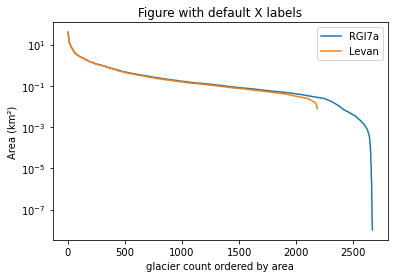

In [95]:
sorted_lev = lev["area"].sort_values(ascending=False)
sorted_RGI_ss = RGI_ss["area"].sort_values(ascending=False)

#sorted_lev()
#sorted_RGI_ss

x = range(len(sorted_RGI_ss))
y = sorted_RGI_ss * 1e-6
x1 = range(len(sorted_lev))
y1 = sorted_lev * 1e-6

plt.plot(x,y,marker="", label="RGI7a")
plt.xlabel("glacier count ordered by area")
plt.ylabel("Area (km²)")
plt.yscale('log')
plt.title("Figure with default X labels")
plt.plot(x1,y1,marker="", label="Levan")
plt.legend(loc="upper right")

plt.show()
#plt.plot(x=range(1, len(sorted_lev)), y=sorted_lev)#, sorted_RGI_ss)

It seems that the small glaciers are not in the 

In [93]:
print(sorted_lev[1000:1010])
print(sorted_RGI_ss[-10:]) # --> makes no sense, we cannot have 3m² glaciers!!!

52      152769.496242
1212    152735.423567
177     152356.952490
110     151984.382663
21      151815.201242
602     151450.918939
557     151421.221016
489     151230.473662
481     150777.205630
538     150707.711575
Name: area, dtype: float64
1596    3.208895
1442    2.597884
1324    2.491136
1644    0.801394
1632    0.250194
1472    0.099646
1565    0.050165
1394    0.029892
1389    0.026114
1353    0.010445
Name: area, dtype: float64
